# Performance Overview

Here, we will example the performance of coherence (and potentially generalize this) as a function of time on several datasets. These investigations were performed on a 4 core machine (4 threads) with a 3.4 GhZ processor.


In [1]:
%%script false

## disklog.sh
#!/bin/bash -e
# run this in the background with nohup ./disklog.sh > disk.txt &
#
while true; do
    echo "$(du -s $1 | awk '{print $1}')"
    sleep 30
done


## cpulog.sh 
import psutil
import time
import argparse

def cpulog(outfile):
    with open(outfile, 'w') as outf:
        while(True):
            cores = psutil.cpu_percent(percpu=True)
            corestr = ",".join([str(core) for core in cores])
            outf.write(corestr + '\n')
            outf.flush()
            time.sleep(1)  # delay for 1 second

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('outfile', help='the file to write core usage to.')
    args = parser.parse_args()
    cpulog(args.outfile)

if __name__ == "__main__":
    main()

    
## memlog.sh
#!/bin/bash -e
# run this in the background with nohup ./memlog.sh > mem.txt &
#
while true; do
    echo "$(free -m | grep buffers/cache | awk '{print $3}')"
    sleep 1
done


## runonesub.sh
# A function for generating memory and cpu summaries for fngs pipeline.
#
# Usage: ./generate_statistics.sh /path/to/rest /path/to/anat /path/to/output

rm -rf $3
mkdir $3

./memlog.sh > ${3}/mem.txt &
memkey=$!
python cpulog.py ${3}/cpu.txt &
cpukey=$!
./disklog.sh $3 > ${3}/disk.txt &
diskkey=$!

res=2mm
atlas='/FNGS_server/atlases/atlas/MNI152_T1-${res}.nii.gz'
atlas_brain='/FNGS_server/atlases/atlas/MNI152_T1-${res}_brain.nii.gz'
atlas_mask='/FNGS_server/atlases/mask/MNI152_T1-${res}_brain_mask.nii.gz'
lv_mask='/FNGS_server/atlases/mask/HarvOx_lv_thr25-${res}.nii.gz'
label='/FNGS_server/atlases/label/desikan-${res}.nii.gz'

exec 4<$1
exec 5<$2

fngs_pipeline $1 $2 $atlas $atlas_brain $atlas_mask $lv_mask $3 none $label --fmt graphml

kill $memkey $cpukey $diskkey

In [2]:
%matplotlib inline
import numpy as np
import re
import matplotlib.pyplot as plt
from IPython.display import Image, display


def memory_function(infile, dataset):
    with open(infile, 'r') as mem:
        lines = mem.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar), linewidth=5)
    ax.set_ylabel(r'mem use (GB)', fontsize=20)
    ax.set_xlabel(r'Time (s)', fontsize=20)
    ax.set_title(r'%s max = %.2f GB; mean = %.2f GB' % (dataset, max(testar) - np.min(testar), np.mean(testar) - np.min(testar)), fontsize=20)
    fig.set_size_inches(8, 2)
    fig.tight_layout()
    return fig

def cpu_function(infile, dataset):
    with open(infile, 'r') as cpuf:
        lines = cpuf.readlines()

    testar = [re.split(',',line.strip()) for line in lines][0:-1]
    
    corear = np.zeros((len(testar), len(testar[0])))
    for i in range(0, len(testar)):
        corear[i,:] = np.array([float(cpu) for cpu in testar[i]])
    
    fig=plt.figure()
    ax = fig.add_subplot(111)
    lines = [ax.plot(corear[:,i], '--', label='cpu '+ str(i), 
                     alpha=0.5, linewidth=5)[0] for i in range(0, corear.shape[1])]
    
    total = corear.sum(axis=1)
    lines.append(ax.plot(total, label='all cores')[0])
    
    labels = [h.get_label() for h in lines]
    
    fig.legend(handles=lines, labels=labels, loc='lower center', prop={'size':20},ncol=2, bbox_to_anchor=(0.5, -.14))
    ax.set_ylabel('CPU use (%)', fontsize=20)
    ax.set_ylim([0, max(total)+10])
    ax.set_xlabel('Time (s)', fontsize=20)
    ax.set_title('%s max = %.1f; mean = %.1f' % (dataset, max(total), np.mean(total)), fontsize=20)
    fig.set_size_inches(8, 2)
    fig.tight_layout()
    return fig

def disk_function(infile, dataset):
    with open(infile, 'r') as disk:
        lines = disk.readlines()

    testar = np.asarray([line.strip() for line in lines]).astype(float)/1000000

    fig=plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(range(0, testar.shape[0]), testar - min(testar))
    ax.set_ylabel('Disk usage GB')
    ax.set_xlabel('Time (30 s)')
    ax.set_title('%s max = %.2f GB; mean = %.2f GB' % (dataset, max(testar) - np.min(testar), np.mean(testar) - np.min(testar)))
    return fig


# BNU 1

/home/eric/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


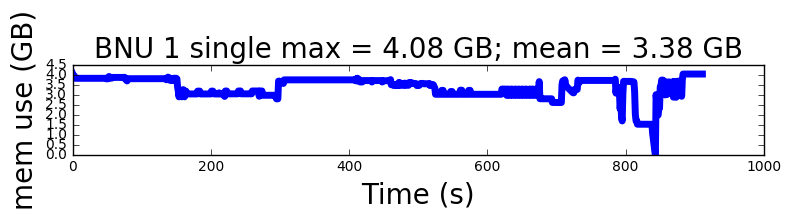

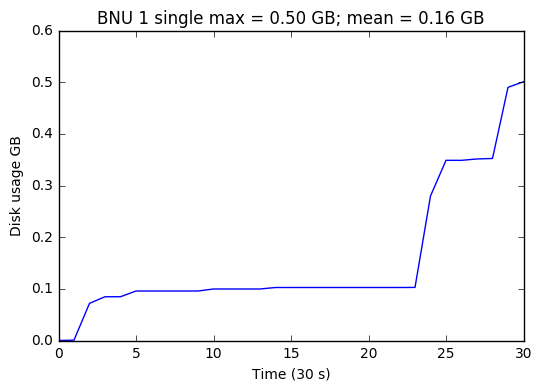

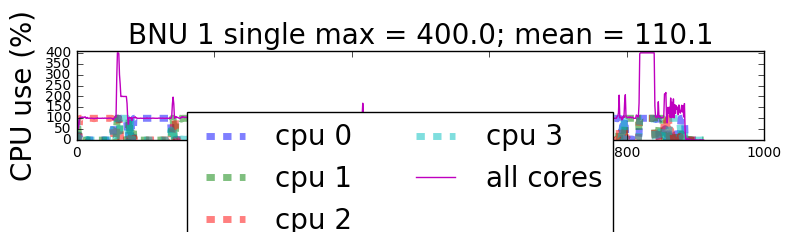

In [3]:
memfig = memory_function('/data/BIDs_test/sub-0025864/outputs/mem.txt', 'BNU 1 single')
diskfig = disk_function('/data/BIDs_test/sub-0025864/outputs/disk.txt', 'BNU 1 single')
cpufig = cpu_function('/data/BIDs_test/sub-0025864/outputs/cpu.txt', 'BNU 1 single')
display(Image(filename='/data/BIDs_test/sub-0025864/outputs/qa/sub-0025864_ses-1_bold/reg/func/align/template/fnirt_score_851/sub-0025864_ses-1_bold_aligned_epi2temp.png'))
memfig.show()
diskfig.show()
cpufig.show()


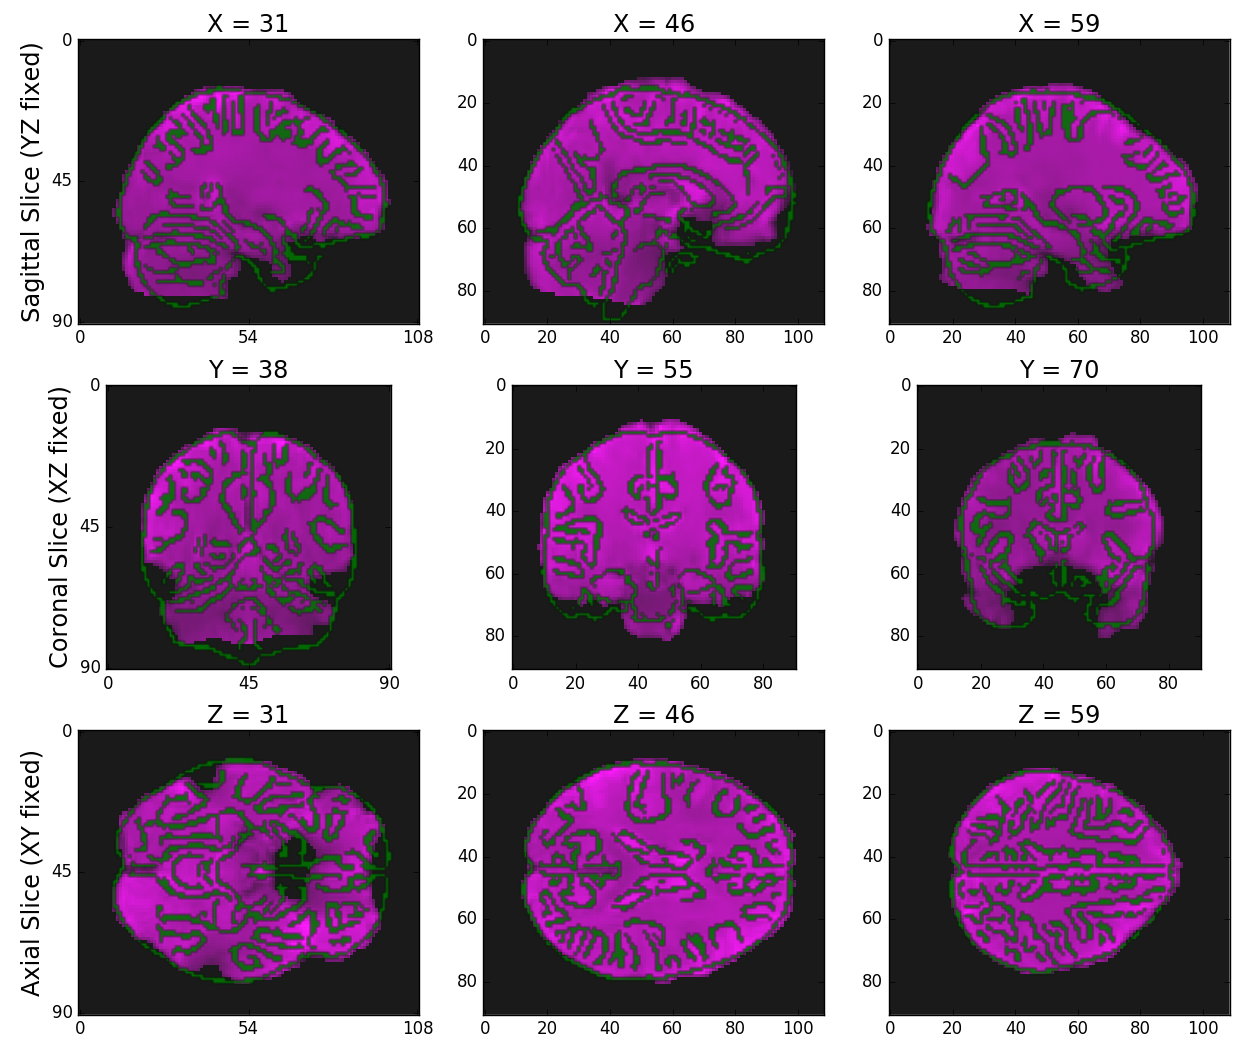

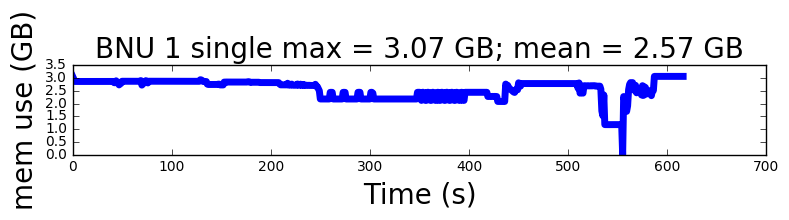

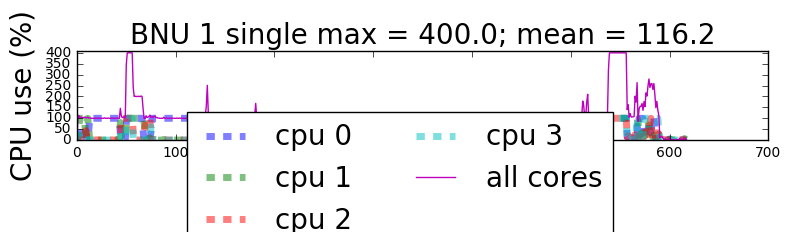

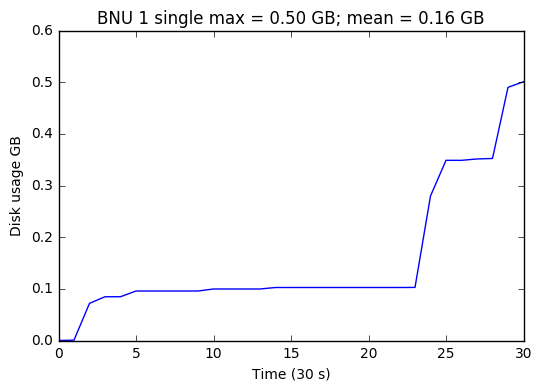

In [16]:
memfig = memory_function('/data/BIDs_test/sub-0025864/outputs_2mm/mem.txt', 'BNU 1 single')
cpufig = cpu_function('/data/BIDs_test/sub-0025864/outputs_2mm/cpu.txt', 'BNU 1 single')
diskfig = disk_function('/data/BIDs_test/sub-0025864/outputs/disk.txt', 'BNU 1 single')
display(Image(filename='/data/BIDs_test/sub-0025864/outputs/qa/sub-0025864_ses-1_bold/reg/func/align/template/fnirt_score_851/sub-0025864_ses-1_bold_aligned_epi2temp.png'))

memfig.show()
cpufig.show()
diskfig.show()

# HNU Dataset

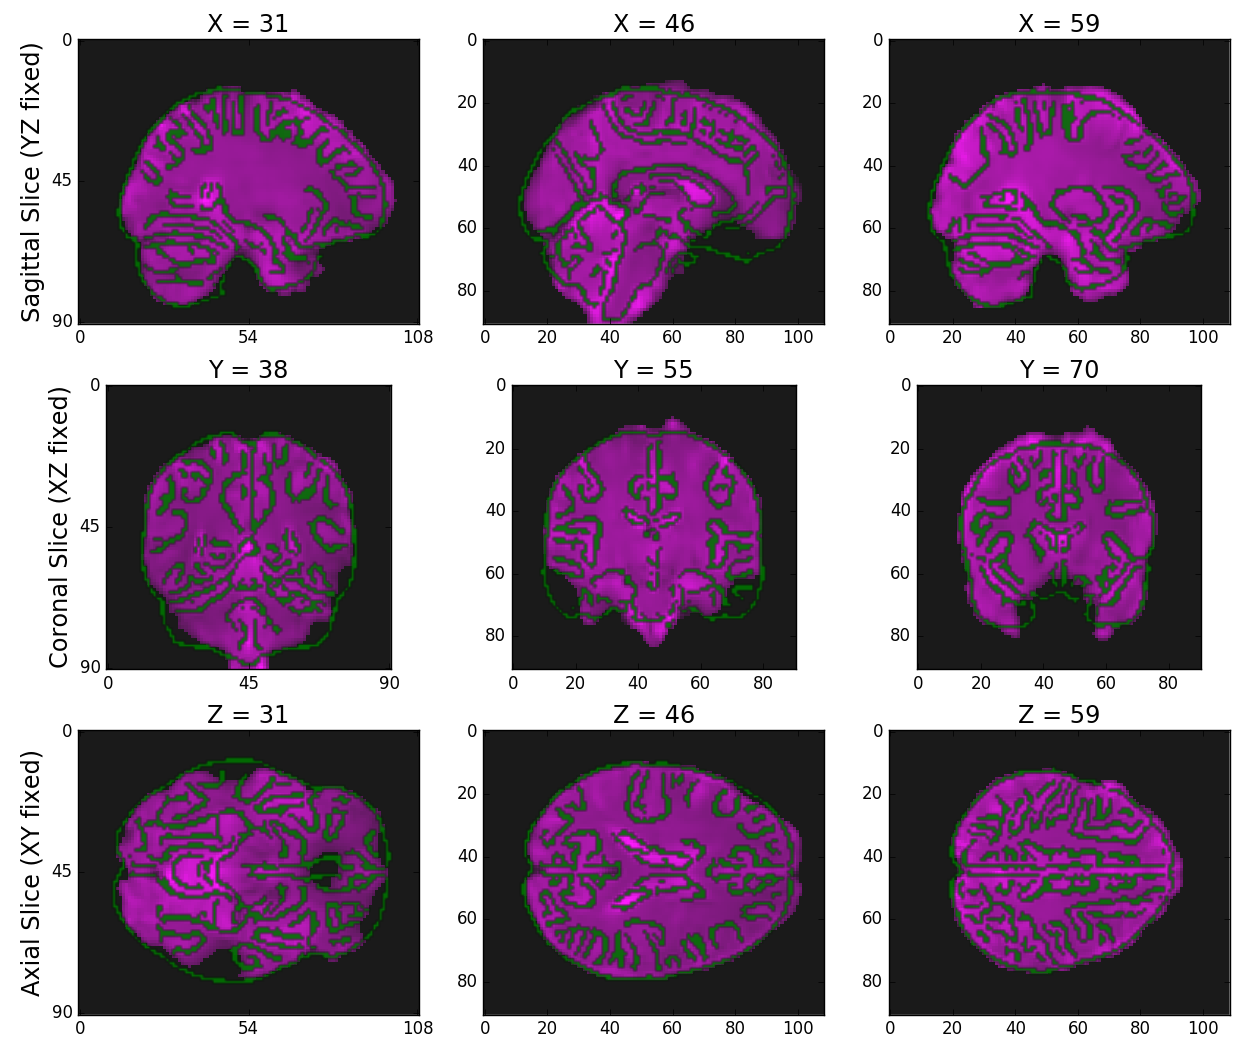

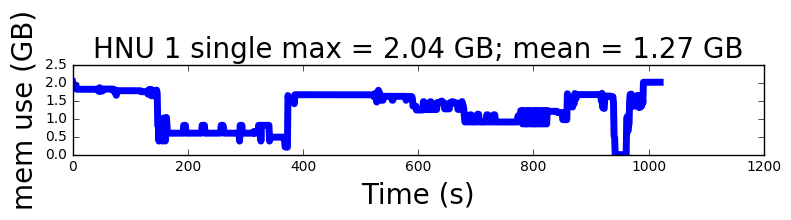

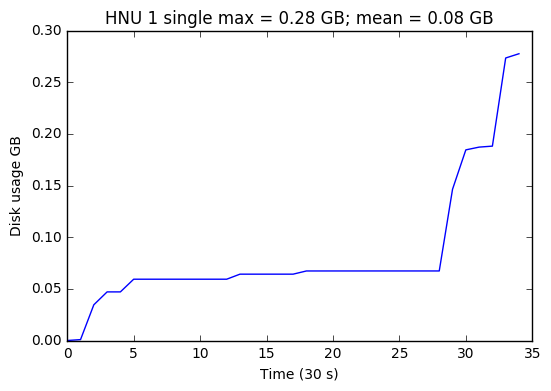

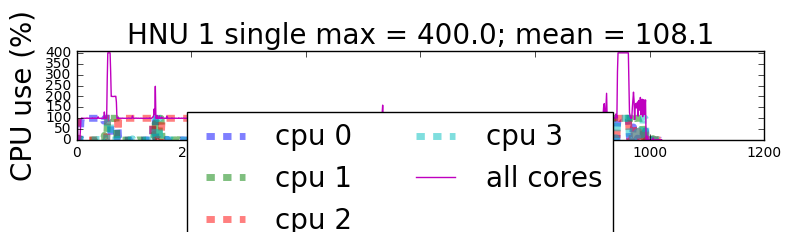

In [15]:

memfig = memory_function('/data/BIDs_test/sub-0025343/outputs/mem.txt', 'HNU 1 single')
diskfig = disk_function('/data/BIDs_test/sub-0025343/outputs/disk.txt', 'HNU 1 single')
cpufig = cpu_function('/data/BIDs_test/sub-0025343/outputs/cpu.txt', 'HNU 1 single')
display(Image(filename='/data/BIDs_test/sub-0025343/outputs_2mm/qa/sub-0027343_ses-1_bold/reg/func/align/template/fnirt_score_869/sub-0027343_ses-1_bold_aligned_epi2temp.png'))

memfig.show()
diskfig.show()
cpufig.show()


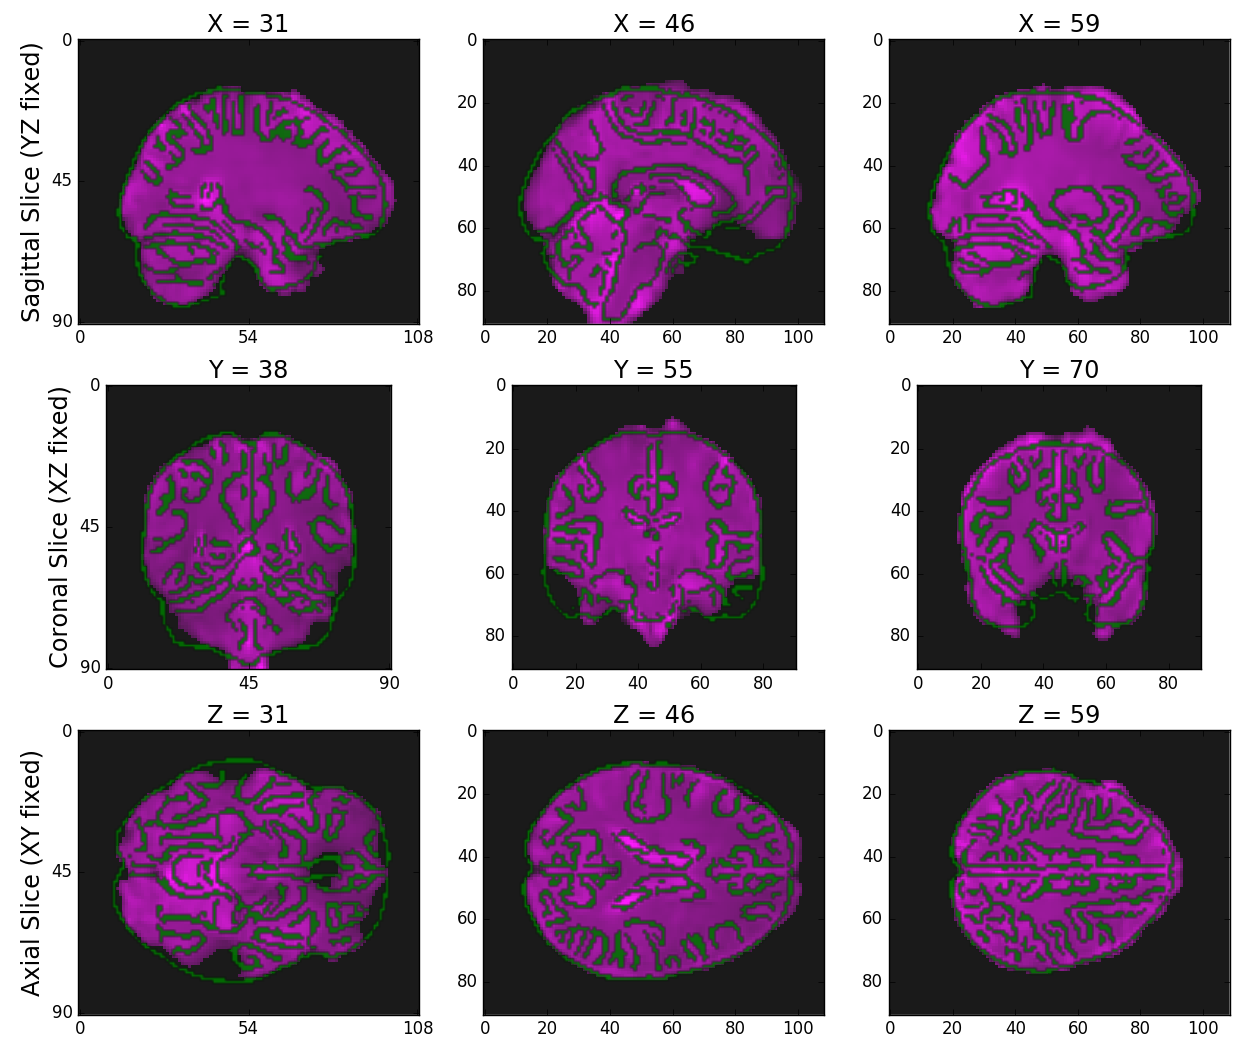

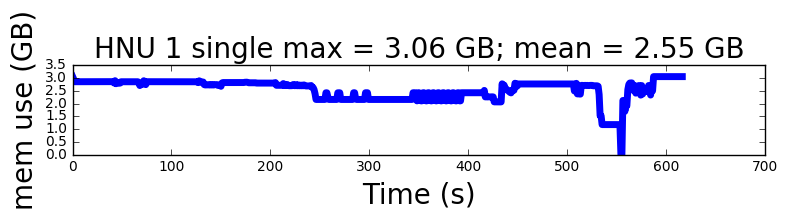

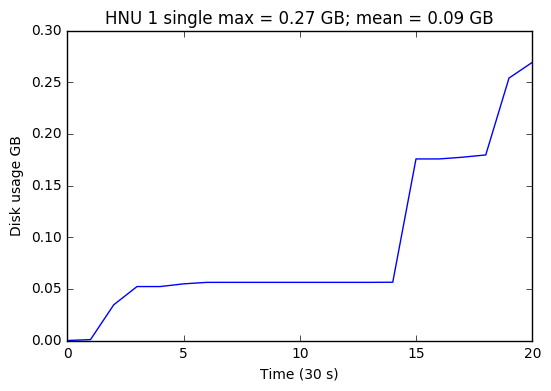

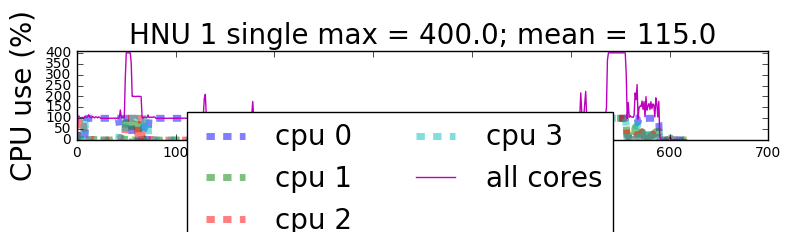

In [14]:

memfig = memory_function('/data/BIDs_test/sub-0025343/outputs_2mm/mem.txt', 'HNU 1 single')
diskfig = disk_function('/data/BIDs_test/sub-0025343/outputs_2mm/disk.txt', 'HNU 1 single')
cpufig = cpu_function('/data/BIDs_test/sub-0025343/outputs_2mm/cpu.txt', 'HNU 1 single')
display(Image(filename='/data/BIDs_test/sub-0025343/outputs_2mm/qa/sub-0027343_ses-1_bold/reg/func/align/template/fnirt_score_869/sub-0027343_ses-1_bold_aligned_epi2temp.png'))

memfig.show()
diskfig.show()
cpufig.show()

# NYU 1 dataset

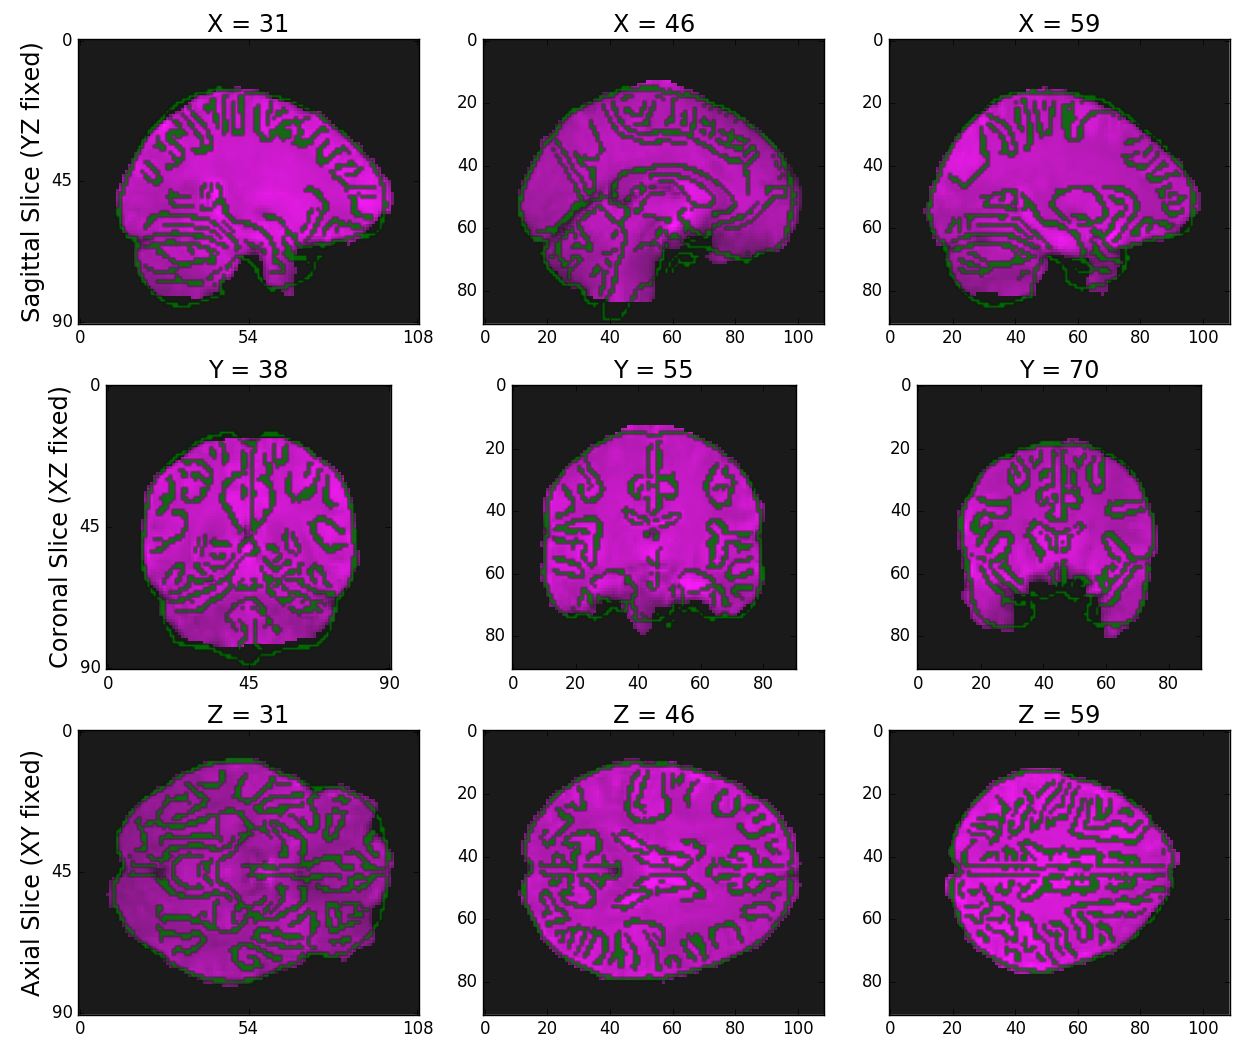

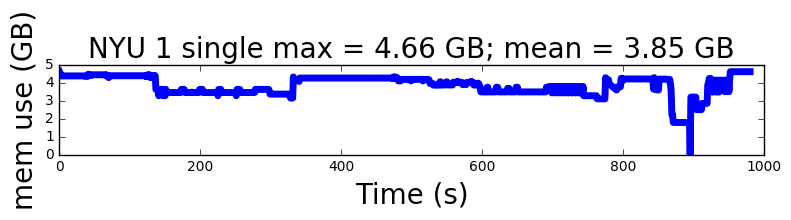

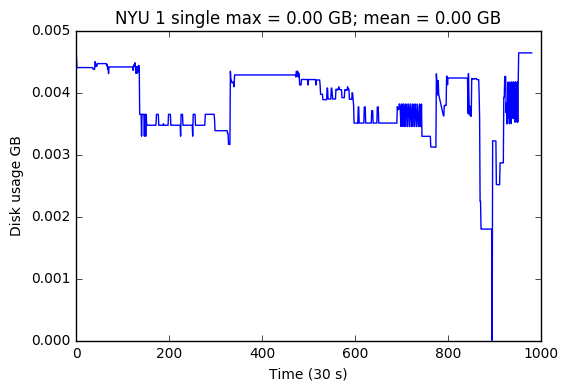

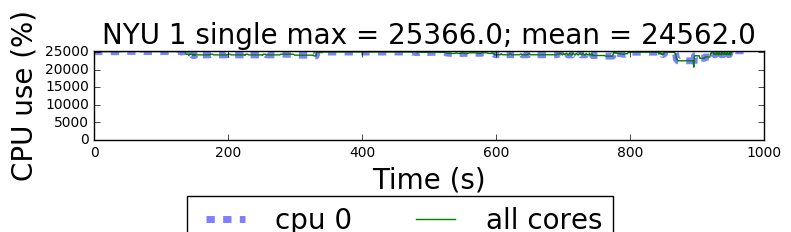

In [8]:
memfig = memory_function('/data/BIDs_test/sub-0027120/outputs/mem.txt', 'NYU 1 single')
diskfig = disk_function('/data/BIDs_test/sub-0027120/outputs/mem.txt', 'NYU 1 single')
cpufig = cpu_function('/data/BIDs_test/sub-0027120/outputs/mem.txt', 'NYU 1 single')
display(Image(filename='/data/BIDs_test/sub-0027120/outputs/qa/sub-0027120_ses-1_bold/reg/func/align/template/fnirt_score_904/sub-0027120_ses-1_bold_aligned_epi2temp.png'))
memfig.show()
diskfig.show()
cpufig.show()

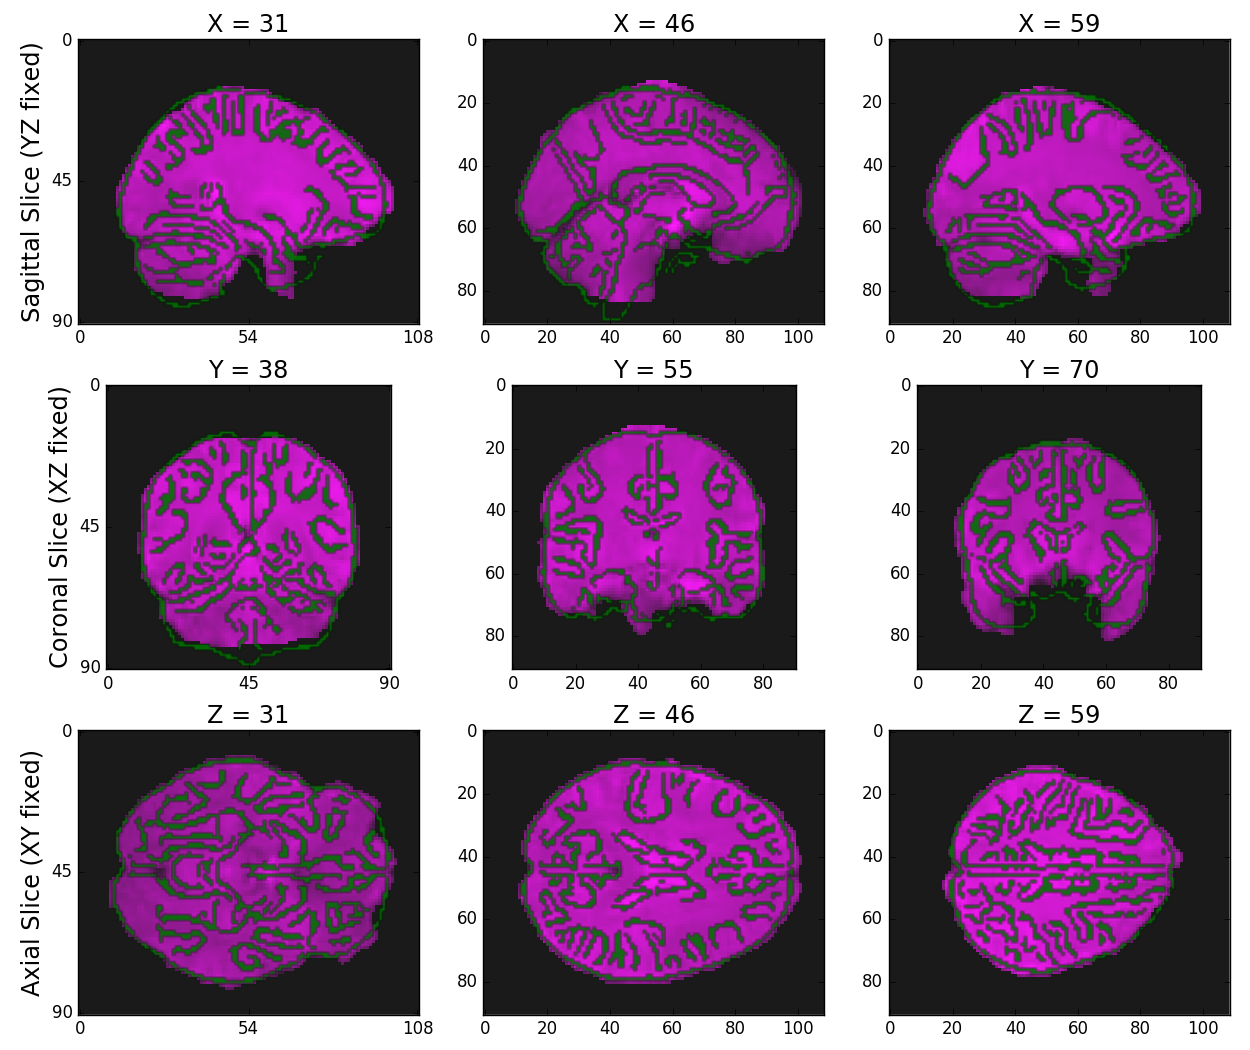

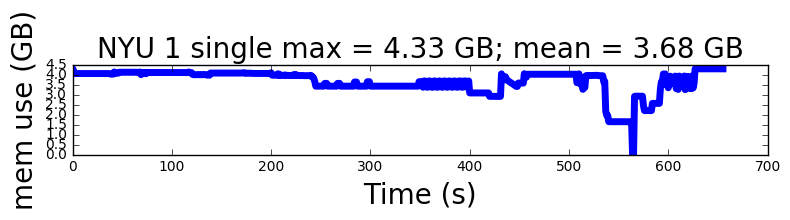

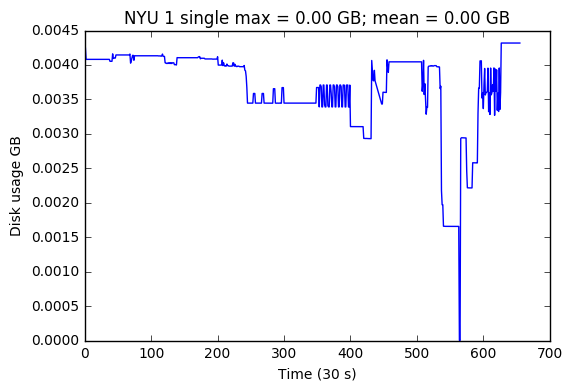

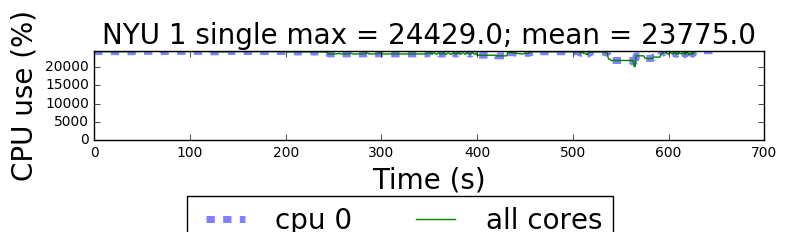

In [11]:

memfig = memory_function('/data/BIDs_test/sub-0027120/outputs_2mm/mem.txt', 'NYU 1 single')
diskfig = disk_function('/data/BIDs_test/sub-0027120/outputs_2mm/mem.txt', 'NYU 1 single')
cpufig = cpu_function('/data/BIDs_test/sub-0027120/outputs_2mm/mem.txt', 'NYU 1 single')
display(Image(filename='/data/BIDs_test/sub-0027120/outputs_2mm/qa/sub-0027120_ses-1_bold/reg/func/align/template/fnirt_score_889/sub-0027120_ses-1_bold_aligned_epi2temp.png'))
memfig.show()
diskfig.show()
cpufig.show()

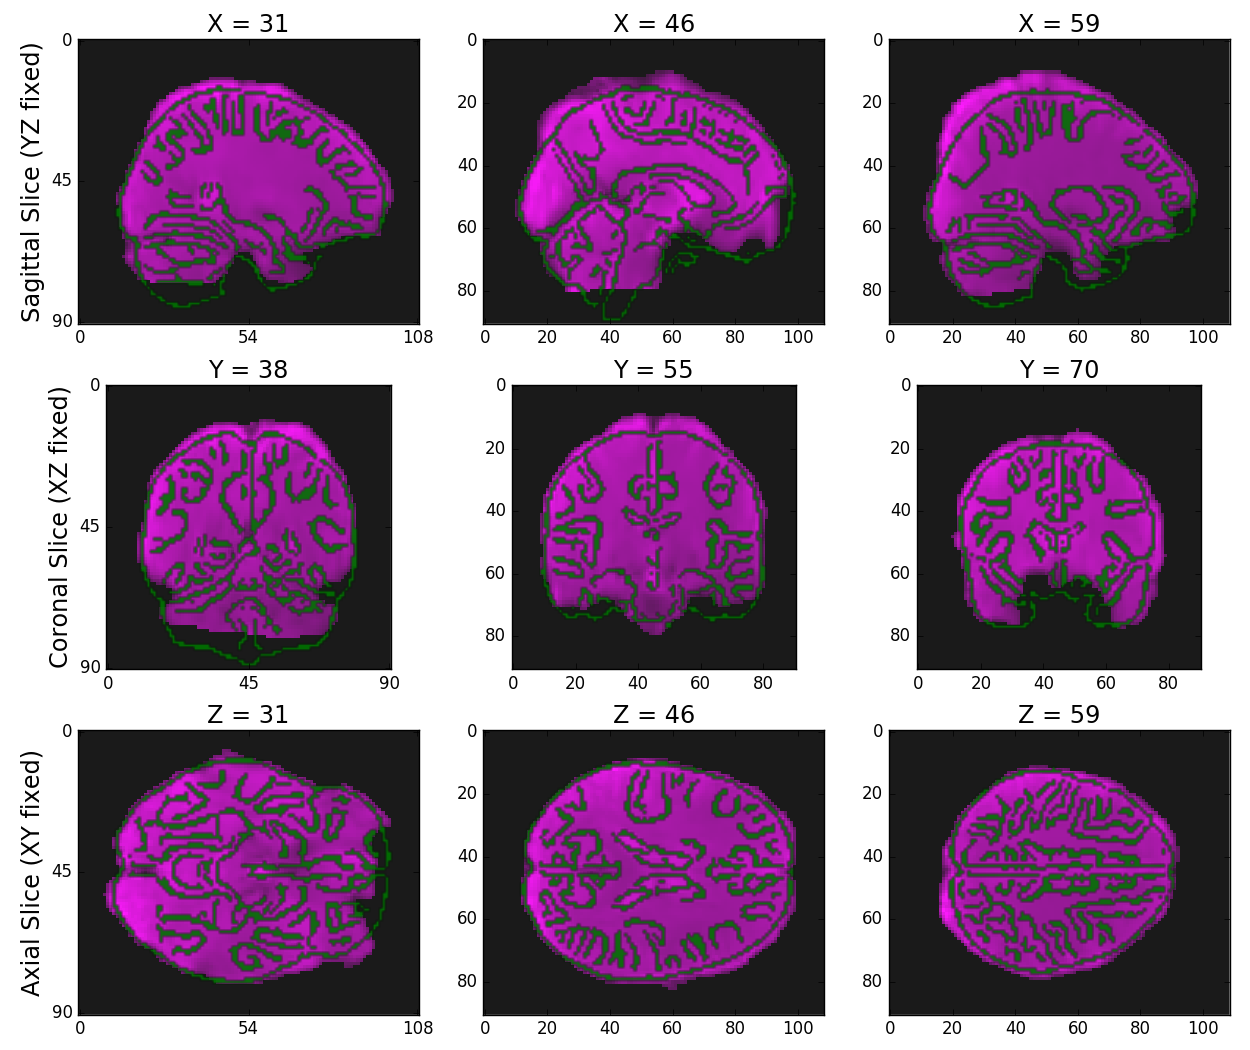

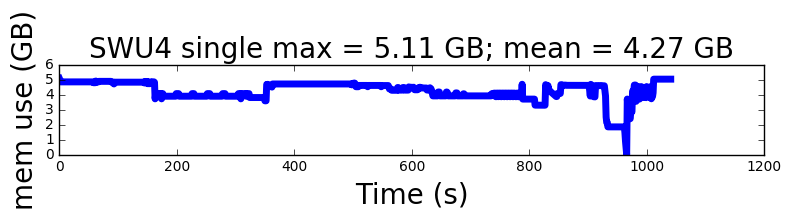

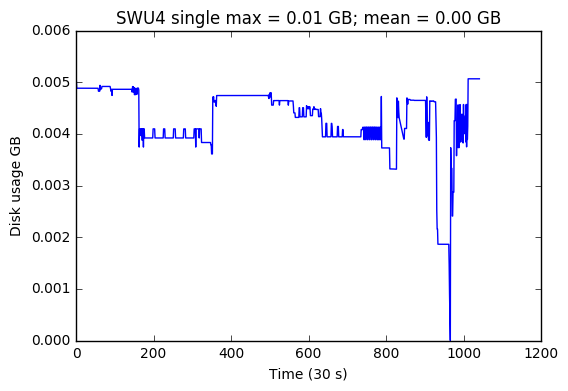

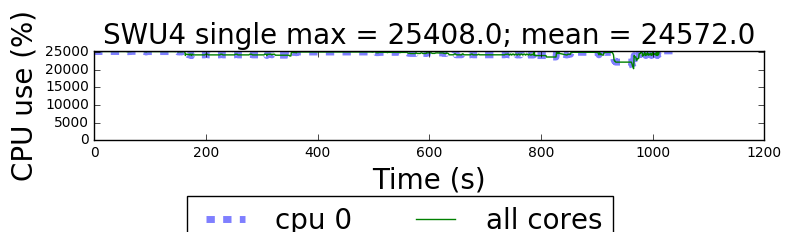

In [13]:
memfig = memory_function('/data/BIDs_test/sub-0025861/outputs/mem.txt', 'SWU4 single')
diskfig = disk_function('/data/BIDs_test/sub-0025861/outputs/mem.txt', 'SWU4 single')
cpufig = cpu_function('/data/BIDs_test/sub-0025861/outputs/mem.txt', 'SWU4 single')
display(Image(filename='/data/BIDs_test/sub-0025861/outputs/qa/sub-0025861_ses-1_bold/reg/func/align/template/fnirt_score_808/sub-0025861_ses-1_bold_aligned_epi2temp.png'))
memfig.show()
diskfig.show()
cpufig.show()

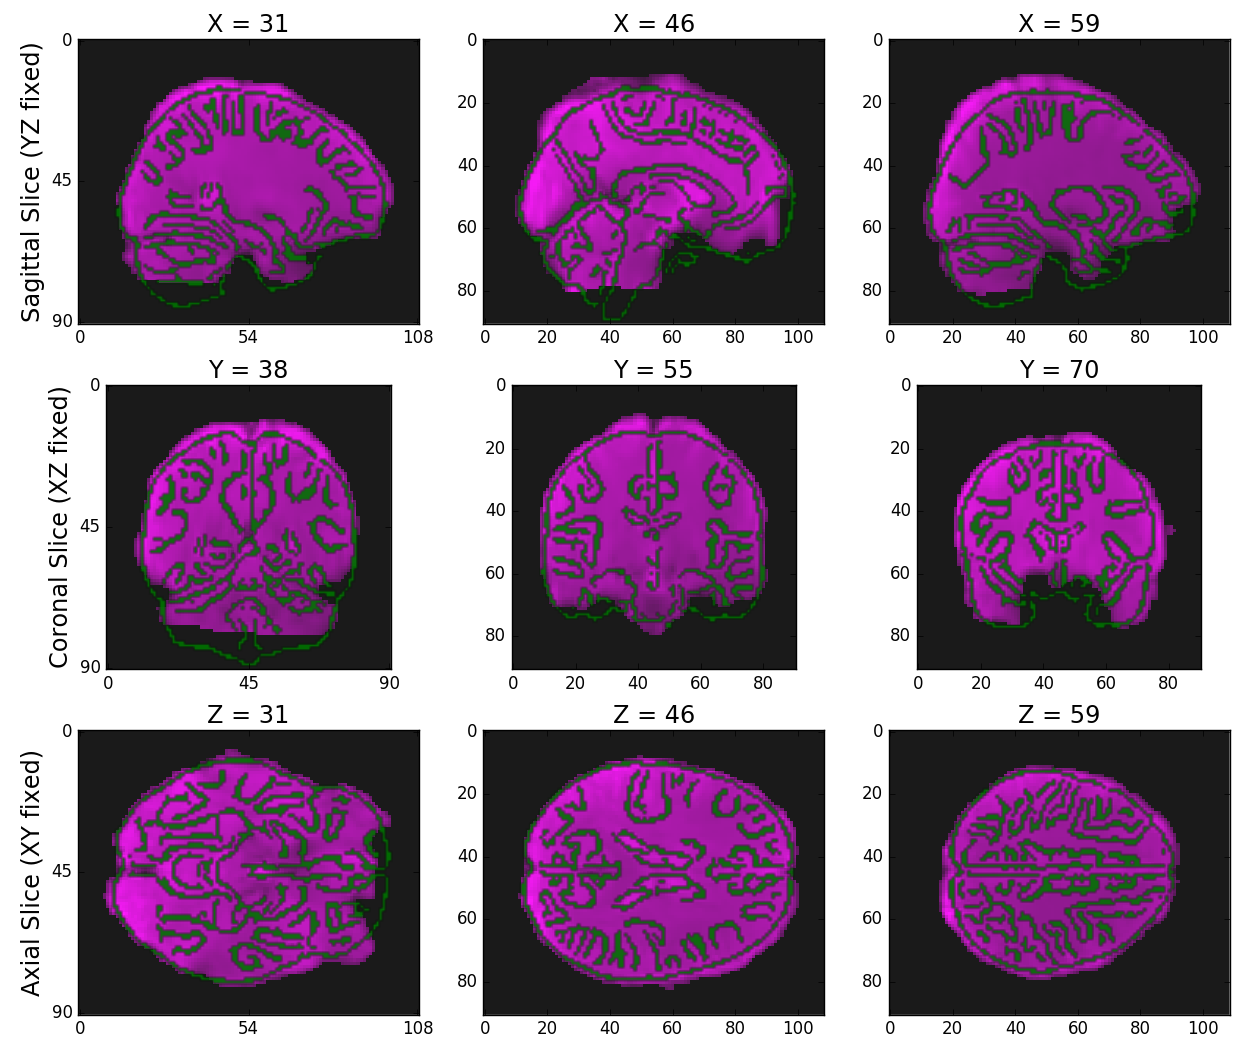

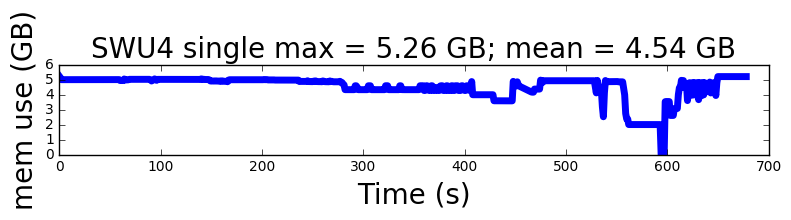

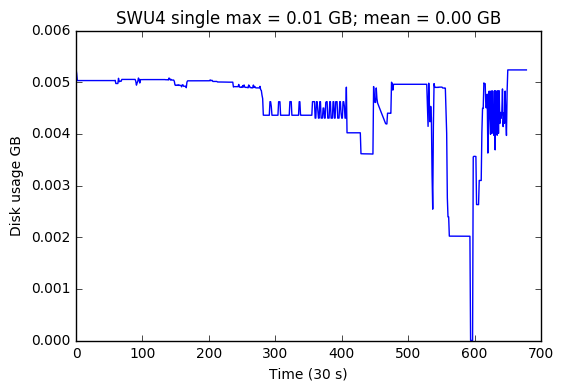

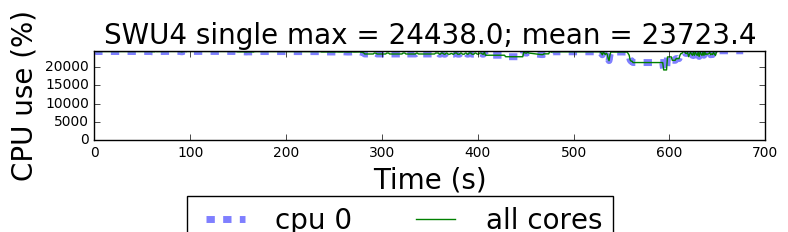

In [12]:
memfig = memory_function('/data/BIDs_test/sub-0025861/outputs_2mm/mem.txt', 'SWU4 single')
diskfig = disk_function('/data/BIDs_test/sub-0025861/outputs_2mm/mem.txt', 'SWU4 single')
cpufig = cpu_function('/data/BIDs_test/sub-0025861/outputs_2mm/mem.txt', 'SWU4 single')
display(Image(filename='/data/BIDs_test/sub-0025861/outputs_2mm/qa/sub-0025861_ses-1_bold/reg/func/align/template/fnirt_score_803/sub-0025861_ses-1_bold_aligned_epi2temp.png'))
memfig.show()
diskfig.show()
cpufig.show()